In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from azure.storage.blob import BlockBlobService
from ghanaconfig import *

In [2]:
block_blob_service = BlockBlobService(account_name=stg_acct, account_key=stg_key)
print('block_blob_service ' + stg_acct + ' storage attached')

block_blob_service ghanamines storage attached


In [5]:
PATH = 'data/ghana/'

In [7]:
!ls {PATH}

saved_models  testing  training  validation


In [8]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [9]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [10]:
sz = 256

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.backends.cudnn.enabled

True

In [13]:
os.listdir(f'{PATH}validation')

['ismine', 'isnotmine', 'iscloud']

In [14]:
files = os.listdir(f'{PATH}validation/ismine')[:5]
files

['033331322133000232.jpg',
 '033331323032201100.jpg',
 '033331322232112303.jpg',
 '033331323033002321.jpg',
 '033331323033030331.jpg']

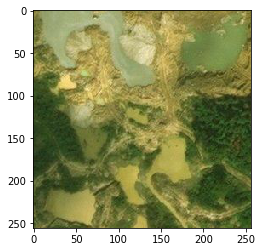

In [15]:
img = plt.imread(f'{PATH}validation/ismine/{files[0]}')
plt.imshow(img);

In [16]:
img.shape

(256, 256, 3)

In [17]:
img[:4,:4]

array([[[146, 137,  68],
        [134, 125,  56],
        [130, 121,  54],
        [137, 129,  64]],

       [[141, 132,  63],
        [131, 122,  55],
        [129, 120,  53],
        [138, 130,  65]],

       [[140, 131,  64],
        [134, 125,  58],
        [136, 129,  61],
        [148, 140,  75]],

       [[140, 131,  64],
        [139, 132,  64],
        [146, 138,  73],
        [153, 148,  82]]], dtype=uint8)

## Our first model

In [20]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), 
                                      trn_name='training', val_name='validation', 
                                      test_name='testing', test_with_labels=True)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


epoch      trn_loss   val_loss   accuracy                  
    0      0.214385   0.113139   0.964349  
    1      0.145284   0.09354    0.967914                  
    2      0.120631   0.093457   0.97148                   



[array([0.09346]), 0.9714795008912656]

## Analyzing results: looking at pictures

In [21]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 2, 2, 2])

In [22]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['iscloud', 'ismine', 'isnotmine']

In [23]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1122, 3)

In [24]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(ismine)

In [25]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [26]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [27]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [28]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


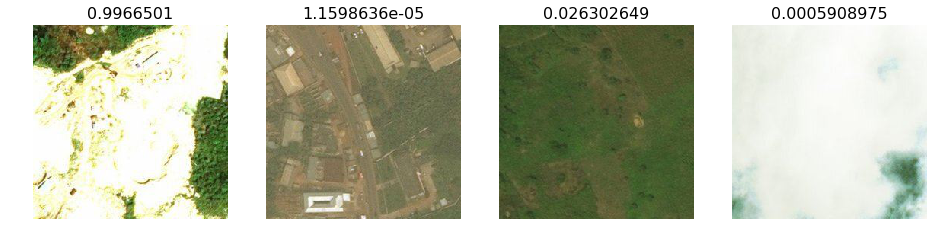

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


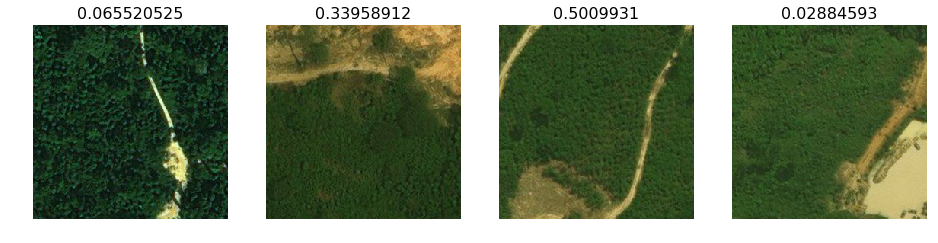

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [31]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct clouds


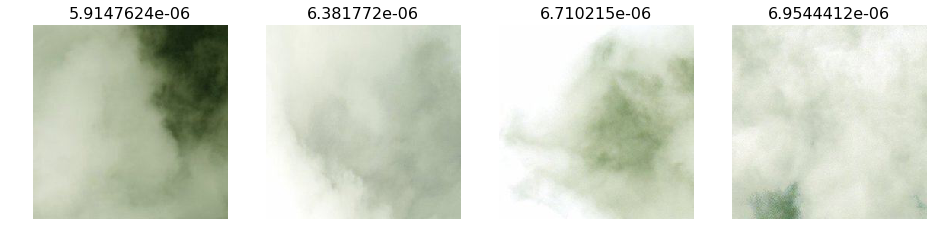

In [32]:
plot_val_with_title(most_by_correct(0, True), "Most correct clouds")

Most correct mines


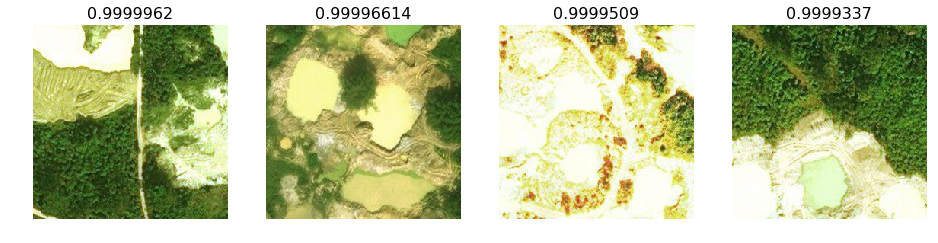

In [34]:
plot_val_with_title(most_by_correct(1, True), "Most correct mines")

Most correct not mines


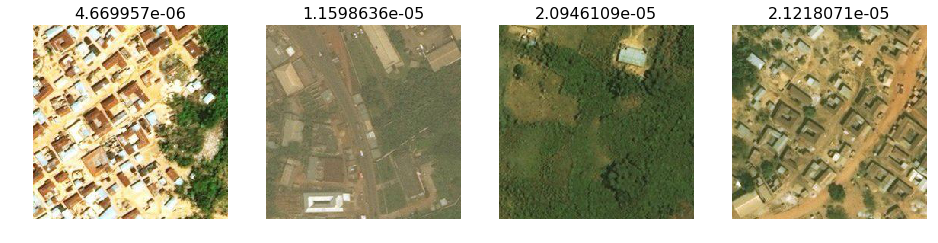

In [35]:
plot_val_with_title(most_by_correct(2, True), "Most correct not mines")

Most incorrect clouds


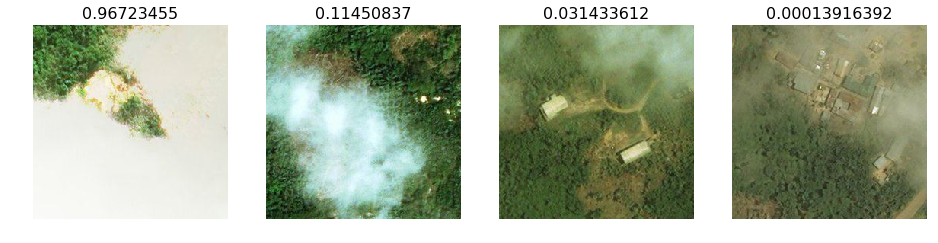

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect clouds")

Most incorrect mines


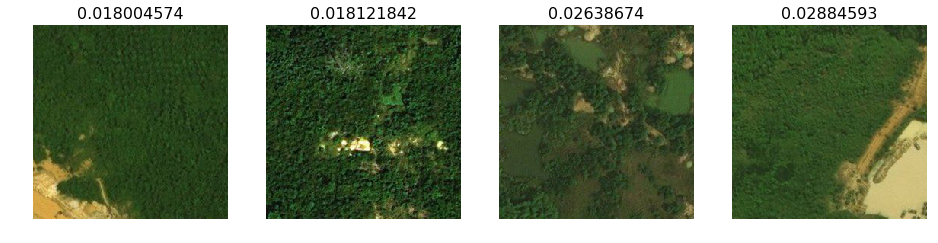

In [37]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect mines")

Most incorrect notmines


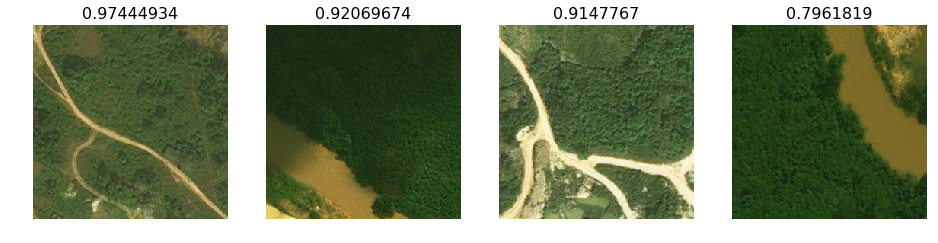

In [38]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect notmines")

## Choosing a learning rate

In [39]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
lrf=learn.lr_find()

 97%|█████████▋| 62/64 [00:01<00:00, 54.25it/s, loss=14.7] 


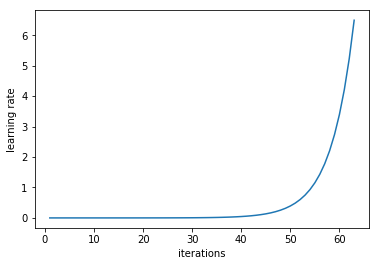

In [41]:
learn.sched.plot_lr()

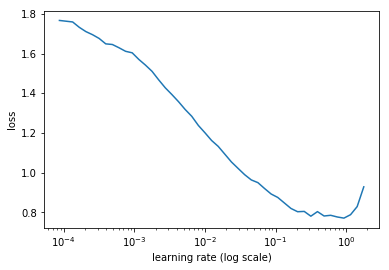

In [42]:
learn.sched.plot()

In [43]:
lr = .1

## Improving our model

In [44]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [45]:
tfms2 = tfms_from_model(arch,sz=sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [48]:
def get_augs(tfms=tfms):
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1, 
                                      trn_name='training', val_name='validation', 
                                      test_name='testing', test_with_labels=True)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [49]:
ims = np.stack([get_augs() for i in range(6)])

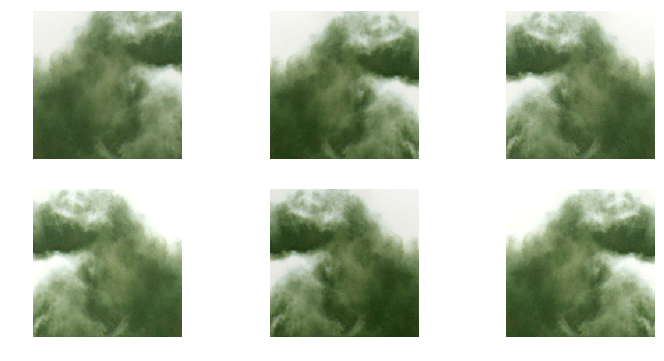

In [50]:
plots(ims, rows=2)

In [51]:
ims2=np.stack([get_augs(tfms=tfms2) for i in range(6)])

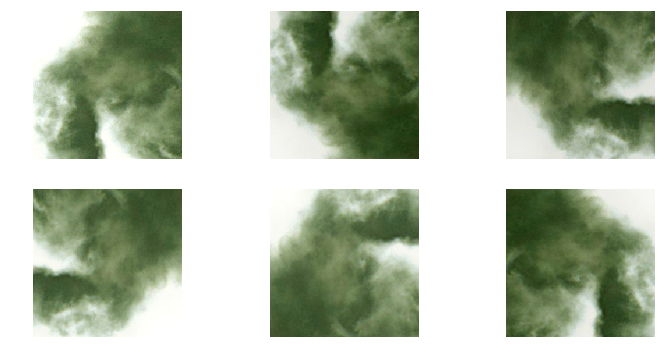

In [52]:
plots(ims2,rows=2)

In [53]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms2, num_workers=1, 
                                      trn_name='training', val_name='validation', 
                                      test_name='testing', test_with_labels=True)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [54]:
learn.fit(lr, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.378087   0.193643   0.960784  



[array([0.19364]), 0.9607843137254902]

In [55]:
learn.precompute=False

In [56]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.225641   0.17627    0.960784  
    1      0.191075   0.112987   0.963458                  
    2      0.182901   0.099119   0.967023                  



[array([0.09912]), 0.9670231720555488]

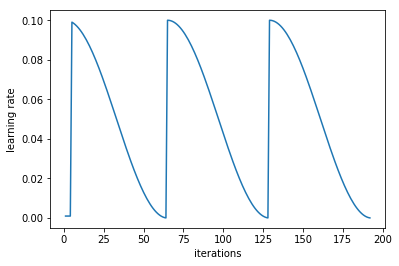

In [57]:
learn.sched.plot_lr()

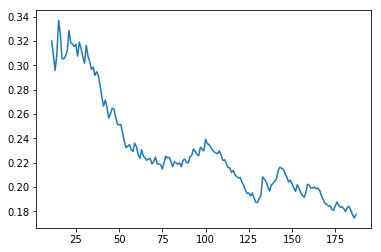

In [58]:
learn.sched.plot_loss()

In [59]:
learn.save('256_lastlayer')

## Fine-tuning and differential learning rate annealing

In [60]:
learn.unfreeze()

In [61]:
lr=np.array([1e-3,1e-2,1e-1])

In [62]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

    1      0.125734   0.051865   0.982175                  
    2      0.110211   0.048403   0.981283                   
    3      0.105393   0.069254   0.972371                   
    4      0.093012   0.043775   0.983957                   
    5      0.062451   0.035033   0.984848                   
    6      0.043418   0.033048   0.983066                   



[array([0.03305]), 0.9830659536541889]

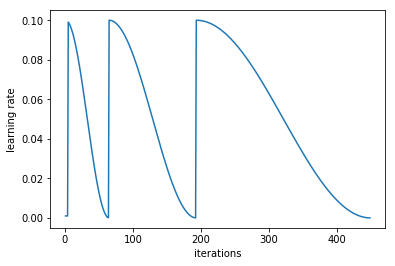

In [63]:
learn.sched.plot_lr()

In [64]:
learn.save('256_all')

In [65]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [66]:
accuracy_np(probs, y)

0.9866310160427807

## Analysing results

In [67]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[379   0   0]
 [  0 206   5]
 [  0  10 522]]


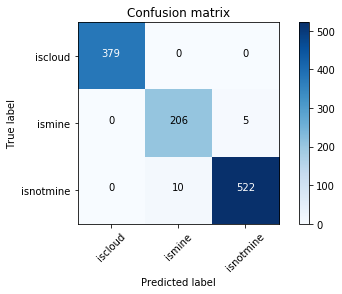

In [69]:
plot_confusion_matrix(cm, data.classes)

In [70]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect clouds")

Most incorrect clouds


<Figure size 1152x576 with 0 Axes>

Most incorrect mines


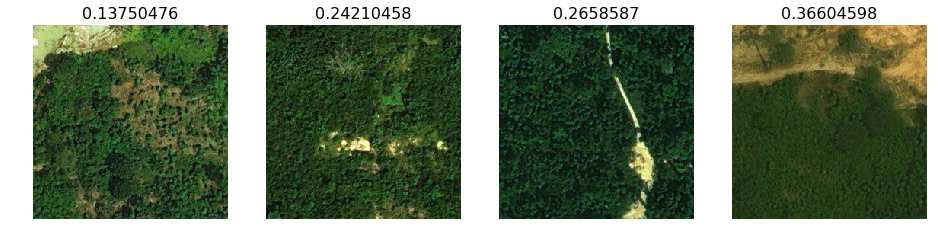

In [71]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect mines")

Most incorrect notmines


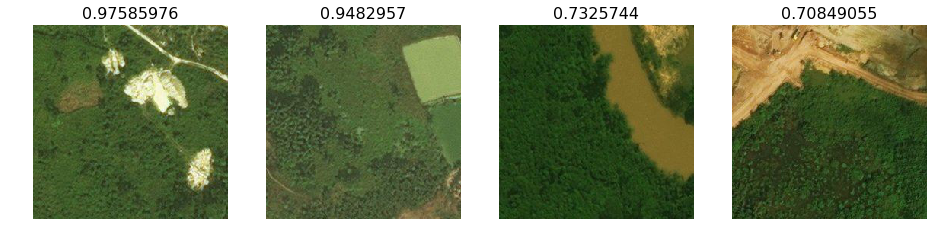

In [73]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect notmines")